## Script to compute the output files for Haiti multimodeling exercice.

This script utilizes the runs done for the sensitivity analysis and computes the different measures used in the paper. It then exports the results as csv files.

In [1]:
from __future__ import division
import numpy as np
import time
import re
import os
import string
import pickle
import imp
# import pymc as pc
import sys
import csv
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from scipy import optimize
import pandas as pd
import calendar
import datetime

In [2]:
def countNumberOfCasesBelow1(x, threshold, M):
    run_length = 0
    for xx in x:
        if xx > threshold:
            run_length = 0
            continue
        run_length += 1
        if run_length >= M:
            return True
        
        
def countNumberOfCasesBelow1_bis(x, threshold, M):
    run_length = 0
    for ivals in range(len(x)):
        xx = x[ivals]
        if xx > threshold:
            run_length = 0
            continue
        run_length += 1
        if run_length >= M:
            return ivals
        
def countCasesLessThan1000PerYear(x, threshold, M):
    myval = int(len(x)-M)
    for jvals in range(myval): 
        mysum = np.sum(x[jvals:(jvals+M)])
        if mysum <= threshold:
            return True
        
        
def countNumberOfCasesBelow1WithIndex(x, threshold, M):
    run_length = 0
    myindex = 0
    for xx in x:
        myindex += 1
        if xx > threshold:
            run_length = 0
            continue
        run_length += 1
        if run_length >= M:
            return myindex
        
def countCasesLessThan1000PerYearWithIndex(x, threshold, M):
    myval = int(len(x)-M)
    for jvals in range(myval): 
        mysum = np.sum(x[jvals:(jvals+M)])
        if mysum <= threshold:
            return jvals
        
def probabilityOfElimination_defA(myMat, threshold, M):
    [dim1, dim2] = np.shape(myMat)
    mycounter = 0
    for ivals in range(dim2):
        x = myMat[:,ivals]
        if countCasesLessThan1000PerYear(x, threshold, M):
            mycounter +=1
    probElimination_a = mycounter/dim2
    return probElimination_a


def listIndicesElimination_defA(myMat, threshold, M):
    [dim1, dim2] = np.shape(myMat)
    myindices = []
    for ivals in range(dim2):
        x = myMat[:,ivals]
        if countCasesLessThan1000PerYear(x, threshold, M):
            myindices.append(ivals)
    
    return myindices

def probabilityOfElimination_defB(myMat, threshold, M):
    [dim1, dim2] = np.shape(myMat)
    mycounter = 0
    for ivals in range(dim2):
        x = myMat[:,ivals]
        if countNumberOfCasesBelow1(x, threshold, M):
            mycounter+=1
    probElimination_b = mycounter/dim2
    return probElimination_b



    
def countResurgenceB(x, threshold, M):
    run_length = 0
    myindex = 0
    for xx in x:
        if xx > threshold:
            run_length = 0
            myindex += 1
            continue
        run_length += 1
        myindex += 1
        if run_length >= M:
            if np.any(x[myindex:]>threshold):
                return True
    
        
def probabilityOfElimination_defB_withoutResurgence(myMat, threshold, M):
    [dim1, dim2] = np.shape(myMat)
    mycounter = 0
    myindices = []
    for ivals in range(dim2):
        x = myMat[:,ivals]
        if countResurgenceB(x, threshold, M):
            myindices.append(ivals)
    print myindices
    temp = np.delete(myMat, myindices, 1)
    print np.shape(temp)
    dim2temp = np.shape(temp)[1]
    goodIndices = []
    for ivals in range(dim2temp):
        x = temp[:,ivals]
        if countNumberOfCasesBelow1(x, threshold, M):
            mycounter+=1
            goodIndices.append(ivals)
    probElimination_b = mycounter/dim2temp   
    return [np.array(goodIndices),probElimination_b]
    
    

def listIndicesElimination__defBWithoutResurgence(myMat, threshold, M):
    [dim1, dim2] = np.shape(myMat)
    mybadindices = []
    myvalues = []
    for ivals in range(dim2):
        x = myMat[:,ivals] #select column
        if countResurgenceB(x, threshold, M):  #check if there is resurgence in that column
            mybadindices.append(ivals)         #if there is, append that index to the list of bad indices
    temp = np.delete(myMat, mybadindices, 1)
    dim2temp = np.shape(temp)[1]
    for ivals in range(dim2temp):
        x = temp[:,ivals]
        myval = countNumberOfCasesBelow1_bis(x, threshold, M)
        if myval != None:
            myvalues.append(myval)
    return [np.array(myvalues), dim2temp]


def listIndicesElimination_defA(myMat, threshold, M):
    [dim1, dim2] = np.shape(myMat)
    myvalues = []
    for ivals in range(dim2):
        x = myMat[:,ivals] 
        myval = countCasesLessThan1000PerYearWithIndex(x, threshold, M)
        if myval != None:
            myvalues.append(myval)
    return [np.array(myvalues), dim2]
    
    
    

def countResurgenceA(x, threshold, M):
    myval = int(len(x)-M)
#     print myval
    for jvals in range(myval): 
        mysum = np.sum(x[jvals:(jvals+M)])
        if mysum <= threshold:
            myindex = jvals
            myval2 = int(len(x[myindex:])-M)
            for kvals in range(myval2):
                mysum = np.sum(x[(myindex+kvals):(myindex+kvals+M)])
                if mysum > threshold:
                    return True
                
                
def countResurgenceA_indices(x, threshold, M):
    myval = int(len(x)-M)
#     print myval
    for jvals in range(myval): 
        mysum = np.sum(x[jvals:(jvals+M)])
        if mysum <= threshold:
            myindex = jvals
            myval2 = int(len(x[myindex:])-M)
            for kvals in range(myval2):
                mysum = np.sum(x[(myindex+kvals):(myindex+kvals+M)])
                if mysum > threshold:
                    return (jvals+kvals)

                
def listIndicesResurgence_defA(myMat, threshold, M):
    [dim1, dim2] = np.shape(myMat)
    mylist = []
    for ivals in range(dim2):
        x = myMat[:,ivals]
        myval = countResurgenceA_indices(x, threshold, M)
        if myval != None:
            mylist.append(myval)
            
    return [np.array(mylist), dim2]

def probabilityOfResurgence_defA(myMat, threshold, M):
    [dim1, dim2] = np.shape(myMat)
    mycounter = 0
    for ivals in range(dim2):
        x = myMat[:,ivals]
        if countResurgenceA(x, threshold, M):
            mycounter +=1
    probResurgence_a = mycounter/dim2
    return probResurgence_a





            
def probabilityOfResurgence_defB(myMat, threshold, M):
    [dim1, dim2] = np.shape(myMat)
    mycounter = 0
    for ivals in range(dim2):
        x = myMat[:,ivals]
        if countResurgenceB(x, threshold, M):
            mycounter+=1
    probResurgence_b = mycounter/dim2
    return probResurgence_b  

def timeToEliminationBsingleColumn(x, threshold, M):
    run_length = 0
    myindex = 0
    for xx in x:
        if xx > threshold:
            run_length = 0
            myindex += 1
            continue
        run_length += 1
        myindex += 1
        if run_length >= M:
            return (myindex - M)
        
def timeToEliminationAsingleColumn(x, threshold, M):
    myval = int(len(x)-M)
#     print myval
    for jvals in range(myval): 
        mysum = np.sum(x[jvals:(jvals+M)])
        if mysum <= threshold:
            return jvals

def timeToElimination_defA(mymat, threshold, M):
    [dim1, dim2] = np.shape(mymat)
    temp = np.zeros(dim2)
    for colvals in range(dim2):
        temp[colvals] = timeToEliminationAsingleColumn(mymat[:, colvals], threshold, M)
    return [int(np.nanmean(temp)), int(np.nanmin(temp)), int(np.nanmax(temp))]

def timeToElimination_defB(mymat, threshold, M):
    [dim1, dim2] = np.shape(mymat)
    temp = np.zeros(dim2)
    for colvals in range(dim2):
        temp[colvals] = timeToEliminationBsingleColumn(mymat[:, colvals], threshold, M)
    return [int(np.nanmean(temp)), int(np.nanmin(temp)), int(np.nanmax(temp))]
    
def computeCumulativeNumberOfCases(myMat):
    temp = np.cumsum(myMat, axis=0)
    temp2 = np.array([np.mean(temp[-1, :]), np.min(temp[-1, :]), np.max(temp[-1, :])])
    temp2[temp2<0] = 0
    return temp2
    

In [3]:
scenarioNums = [0, 1, 2, 3, 4, 25]
mywidth = 'width0.25_fracSusWidth0.1'
matNames = ['cases', 'casesVac', 'casesDoNothing', 'redFrac']
mydf = []
today = time.strftime("%Y%b%d", time.localtime())
mydate = '30May2019'

In [4]:
#compute the probability of elimination and store in csv files

# mydate = '13May2019'
# mywidth = 'width0.25_fracSusWidth0.1'
# matNames = ['cases', 'casesVac', 'casesDoNothing', 'redFrac']
# mydf = []
# today = time.strftime("%Y%b%d", time.localtime())
for scevals in range(6):
    print 'scenario', scenarioNums[scevals]
    myfullpath = 'mainResults2019AllInfections/sensitivityAnalysisMatrices/' + \
                'matrixResultForScenario_' + str(scenarioNums[scevals]) + '_' + str(mywidth) + 'width_20.0repRate' + mydate + '.pickle'
#                   str(scenarioNums[scevals]) + '_' + 'casesVac' + '_' + str(mywidth) + 'width_20.0repRate'+ today + '.pickle'
    f = open(myfullpath, 'r')
    temp = pickle.load(f)
    f.close()
    myMat = temp[1]
    [dim1, dim2] =  np.shape(myMat)
    
    mycutoffs = [3, 5, 10]
    for ivals in range(3):
        mytempMat = myMat[:52*mycutoffs[ivals], :]
        temp =  computeCumulativeNumberOfCases(mytempMat)
        mydf.append({'team': 'FredHutch_UF', 'scenario': scenarioNums[scevals], 'time_frame': mycutoffs[ivals], 
                     'pr_elim_thresh1': probabilityOfElimination_defA(mytempMat, 1000, 52),
                     'pr_elim_thresh2': probabilityOfElimination_defB(mytempMat, 1, 52),
                     'pr_resurg_thresh1': probabilityOfResurgence_defA(mytempMat, 1000, 52),
                   'pr_resurg_thresh2': probabilityOfResurgence_defB(mytempMat, 1, 52), 
                    'cum_inf_med': temp[0], 
                     'cum_inf_low': temp[1], 
                     'cum_inf_hi': temp[2]})


mydf = pd.DataFrame(mydf)

     
mydf = mydf[['team', 'scenario', 'time_frame', 'pr_elim_thresh1', 'pr_resurg_thresh1', 'pr_elim_thresh2', 'pr_resurg_thresh2',
          'cum_inf_med', 'cum_inf_low', 'cum_inf_hi']]


print mydf

#store the data frame in a csv file:
myoutputfilename = 'mainResults2019AllInfections/CSVfiles/pr_elim_AllRunsFredHutch_UF_' + today + '.csv'
mydf.to_csv(myoutputfilename, index=False)

scenario 0
scenario 1
scenario 2
scenario 3
scenario 4
scenario 25
            team  scenario  time_frame  pr_elim_thresh1  pr_resurg_thresh1  \
0   FredHutch_UF         0           3         0.167665           0.000000   
1   FredHutch_UF         0           5         0.215569           0.000000   
2   FredHutch_UF         0          10         0.334331           0.000000   
3   FredHutch_UF         1           3         1.000000           0.000000   
4   FredHutch_UF         1           5         1.000000           0.004990   
5   FredHutch_UF         1          10         1.000000           0.062874   
6   FredHutch_UF         2           3         0.177645           0.000000   
7   FredHutch_UF         2           5         0.242515           0.000000   
8   FredHutch_UF         2          10         0.417166           0.000000   
9   FredHutch_UF         3           3         0.344311           0.000000   
10  FredHutch_UF         3           5         0.999002           0.000000 

In [5]:
#generate csv file for time to elimination:
df2 = []
vacdates = ['NA'] + 5*['2019-01-12']
for scevals in range(6):
    print 'scenario', scenarioNums[scevals]
    myfullpath = 'mainResults2019AllInfections/sensitivityAnalysisMatrices/' + \
                'matrixResultForScenario_' + str(scenarioNums[scevals]) + '_' + str(mywidth) + 'width_20.0repRate' + mydate + '.pickle'
#                   str(scenarioNums[scevals]) + '_' + 'casesVac' + '_' + str(mywidth) + 'width_20.0repRate'+ today + '.pickle'
    f = open(myfullpath, 'r')
    temp = pickle.load(f)
    f.close()
    myMat = temp[1]

    timeA = timeToElimination_defA(myMat, 1000, 52)
    timeB = timeToElimination_defB(myMat, 1, 52)
    [dim1, dim2] =  np.shape(myMat)
    df2.append({'team': 'FredHutch_UF', 'scenario': scenarioNums[scevals], 
                't_elim_thresh1_med': timeA[0], 
                't_elim_thresh1_low': timeA[1],
                't_elim_thresh1_hi': timeA[2],
                  't_elim_thresh2_med': timeB[0], 
                't_elim_thresh2_low': timeB[1],
                't_elim_thresh2_hi': timeB[2],
                'vacc_startdate': vacdates[scevals]})
    
df2 = pd.DataFrame(df2)
df2 = df2[['team', 'scenario', 't_elim_thresh1_med',
                't_elim_thresh1_low',
                't_elim_thresh1_hi',
                  't_elim_thresh2_med', 
                't_elim_thresh2_low',
                't_elim_thresh2_hi',
                'vacc_startdate']] 
#save to csv:  
myoutputfilename = 'mainResults2019AllInfections/CSVfiles/tte_AllRunsFredHutch_UF_' + today + '.csv'
df2.to_csv(myoutputfilename, index=False)

scenario 0
scenario 1
scenario 2
scenario 3
scenario 4
scenario 25


In [129]:
#generate csv files for the time series

#open the "best" simulation that was actually generated with the mean parameter set. This will be stored as the mean column
bestname = 'mainResults2019AllInfections/sensitivityAnalysis/mainResults_1to4and2510May2019_bestParamsMean.pickle'
f = open(bestname, 'r')
best = pickle.load(f)
f.close()

#store the doNothing runs as scenario 0 for the mean parameter set:
doNothing = best[1][4]
best.insert(0, doNothing)
print len(best)

#open the pickle file with the number of doses per week for each scenario:
doseName = 'mainResults2019AllInfections/numberOfDosesPerWeekAllScenarios16May2019.pickle'
f = open(doseName, 'r')
dosesPerWeek = pickle.load(f)
f.close()

#fraction of observed cases: 20% of all infections are symptomatic, and 20% of those are observed (reported):
myfrac = 0.2*0.2

haitiPop = 10911819
tsdf = []

#loop through all scenarios:
for scevals in range(6):
    print 'scenario', scenarioNums[scevals]
    myfullpath = 'mainResults2019AllInfections/sensitivityAnalysisMatrices/' + \
                'matrixResultForScenario_' + str(scenarioNums[scevals]) + '_' + str(mywidth) + 'width_20.0repRate' + mydate + '.pickle'
#                   str(scenarioNums[scevals]) + '_' + 'casesVac' + '_' + str(mywidth) + 'width_20.0repRate'+ today + '.pickle'
    f = open(myfullpath, 'r')
    temp = pickle.load(f)
    f.close()
    myMat = temp[1]
    [dim1, dim2] =  np.shape(myMat)
    
    bestTemp = best[scevals]

    if scevals == 0:
        tempDoses = np.array(dim1*['NA'], dtype = 'str')
        bestCasesVac = bestTemp
    else:    
        tempDoses = dosesPerWeek[scevals-1]
        tempDoses = tempDoses.astype(np.int64)
        bestCasesVac = bestTemp[3]
        
    dim1doses = len(tempDoses)
    print dim1doses
    
    #create a dataframe with the dates (kind of an overkill):
    mydates = pd.DataFrame()
    mydates['my_date'] = pd.date_range(start='1/12/2019', periods=dim1, freq='W') - pd.Timedelta('1 day')
    
    for ivals in range(dim1doses):
        tsdf.append({'team': 'FredHutch_UF', 'scenario': scenarioNums[scevals],
                     'obs_cases_med': int(myfrac*bestCasesVac[ivals]),   
                     'obs_cases_low': int(myfrac*np.min(myMat[ivals, :])),
                     'obs_cases_hi' : int(myfrac*np.max(myMat[ivals, :])),
                     'true_inf_med': (bestCasesVac[ivals]),
                     'true_inf_low': (np.min(myMat[ivals, :])),
                     'true_inf_hi': (np.max(myMat[ivals, :])),
                     'population_size': haitiPop,
                     'vacc_med': tempDoses[ivals],
                     'vacc_low': tempDoses[ivals],
                     'vacc_hi': tempDoses[ivals],
                     'saturday_date': mydates.my_date[ivals]}
                     )
    
    if scevals !=0:
        for ivals in range(dim1doses, dim1):
            tsdf.append({'team': 'FredHutch_UF', 'scenario': scenarioNums[scevals],
                     'obs_cases_med': int(myfrac*bestCasesVac[ivals]),   
                     'obs_cases_low':int( myfrac*np.min(myMat[ivals, :])),
                     'obs_cases_hi' : int(myfrac*np.max(myMat[ivals, :])),
                     'true_inf_med': (bestCasesVac[ivals]),
                     'true_inf_low': (np.min(myMat[ivals, :])),
                     'true_inf_hi': (np.max(myMat[ivals, :])),
                     'population_size': haitiPop,
                     'vacc_med': 0,
                     'vacc_low': 0,
                     'vacc_hi': 0, 
                     'saturday_date': mydates.my_date[ivals]}
                     )
        
        
#append a column with the date:
tsdf = pd.DataFrame(tsdf)

#reorder the data frame:
tsdf = tsdf[['team', 'scenario',
                     'saturday_date',
                     'obs_cases_med',   
                     'obs_cases_low',
                     'obs_cases_hi' ,
                     'true_inf_med',
                     'true_inf_low',
                     'true_inf_hi',
                     'population_size',
                     'vacc_med',
                     'vacc_low',
                     'vacc_hi',
                     ]]
    

# #save to csv:  
# myoutputfilename = 'mainResults2019AllInfections/CSVfiles/ts_FredHutch_UF_' + today + '.csv'
# tsdf.to_csv(myoutputfilename, index=False)

6
scenario 0
521
scenario 1
103
scenario 2
105
scenario 3
259
scenario 4
105
scenario 25
103


In [130]:
tsdf

,team,scenario,saturday_date,obs_cases_med,obs_cases_low,obs_cases_hi,true_inf_med,true_inf_low,true_inf_hi,population_size,vacc_med,vacc_low,vacc_hi
0,FredHutch_UF,0,2019-01-12,64,0,878,1605.603169,-1.612170e-08,2.196785e+04,10911819,NA,NA,NA
1,FredHutch_UF,0,2019-01-19,66,0,884,1651.933427,-2.129400e-08,2.210068e+04,10911819,NA,NA,NA
2,FredHutch_UF,0,2019-01-26,67,0,877,1681.568270,-9.651558e-09,2.192774e+04,10911819,NA,NA,NA
3,FredHutch_UF,0,2019-02-02,67,0,858,1692.770440,-2.309753e-08,2.146089e+04,10911819,NA,NA,NA
4,FredHutch_UF,0,2019-02-09,67,0,829,1684.604505,-4.726644e-09,2.072623e+04,10911819,NA,NA,NA
5,FredHutch_UF,0,2019-02-16,66,0,790,1657.054201,-4.701178e-09,1.976134e+04,10911819,NA,NA,NA
6,FredHutch_UF,0,2019-02-23,64,0,744,1611.061112,-4.785306e-09,1.861187e+04,10911819,NA,NA,NA
7,FredHutch_UF,0,2019-03-02,61,0,693,1548.474222,-5.848051e-09,1.732801e+04,10911819,NA,NA,NA
8,FredHutch_UF,0,2019-03-09,58,0,638,1471.913990,-3.499736e-09,1.596093e+04,10911819,NA,NA,NA
9,FredHutch_UF,0,2019-03-16,55,0,582,1384.565330,-3.776677e-09,1.455969e+04,10911819,NA,NA,NA


In [12]:
tsdf.loc[tsdf['saturday_date']== '2028-12-09']


,team,scenario,saturday_date,obs_cases_med,obs_cases_low,obs_cases_hi,true_inf_med,true_inf_low,true_inf_hi,population_size,vacc_med,vacc_low,vacc_hi
517,FredHutch_UF,0,2028-12-09,0,0,823,1.203413,-1.664739e-08,20580.754835,10911819,NA,NA,NA
1038,FredHutch_UF,1,2028-12-09,0,0,371,0.000000,-1.629815e-08,9277.416619,10911819,0,0,0
1557,FredHutch_UF,2,2028-12-09,0,0,583,0.001508,-6.461050e-09,14584.786410,10911819,0,0,0
2078,FredHutch_UF,3,2028-12-09,0,0,366,0.000000,-2.607703e-08,9159.063227,10911819,0,0,0
2597,FredHutch_UF,4,2028-12-09,0,0,604,0.000000,-2.584420e-08,15120.580760,10911819,0,0,0
3118,FredHutch_UF,25,2028-12-09,0,0,395,0.000000,-1.513399e-08,9889.201389,10911819,0,0,0


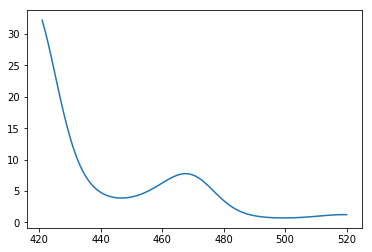

In [34]:
temp2 = tsdf.loc[tsdf['scenario']== 0].copy()
temp2 = temp2[-100:]
# plt.plot(temp2['true_inf_med'])
plt.plot(temp2[ 'true_inf_med'])

In [5]:
#rerun the probablity of elimination excluding those simulations for which the elimination happened before the beginning of vaccination:
scenarioNums = [0, 1, 2, 3, 4, 25]
mydate = '30May2019'
mywidth = 'width0.25_fracSusWidth0.1'
matNames = ['cases', 'casesVac', 'casesDoNothing', 'redFrac']
mydf2 = []
today = time.strftime("%Y%b%d", time.localtime())
for scevals in range(6):
    print 'scenario', scenarioNums[scevals]
    myfullpath = 'mainResults2019AllInfections/sensitivityAnalysisMatrices/' + \
                'matrixResultForScenario_' + str(scenarioNums[scevals]) + '_' + str(mywidth) + 'width_20.0repRate' + mydate + '.pickle'
#                   str(scenarioNums[scevals]) + '_' + 'casesVac' + '_' + str(mywidth) + 'width_20.0repRate'+ today + '.pickle'
    f = open(myfullpath, 'r')
    temp = pickle.load(f)
    f.close()
    
    #stack the matrices of pre-vaccination and vaccination on top of each other to exclude the simulations where elimination happened
    #before the start of vaccination
    cases = temp[0]
    casesVac = temp[1]
    [m1, n1] =  np.shape(cases)
    [m2, n2] =  np.shape(casesVac)
#     print [m1, n1, m2, n2]

    fullMat = np.vstack((cases, casesVac))

    M = 52
    indexListB = []
    indexListA = []
    for jvals in range(n2):
        x = fullMat[:, jvals]
        tempB = countNumberOfCasesBelow1WithIndex(x, 1, M)
        if tempB != None:
            temp2 = tempB - M
            if (temp2) < m1:
                indexListB.append(jvals)
                
        tempA = countCasesLessThan1000PerYearWithIndex(x, 1000, M)
        if tempA != None:
#             print tempA
            if (tempA) < m1:
#                 print jvals
                indexListA.append(jvals)
            

    newVacMatB = np.delete(casesVac, indexListB, 1)
    newVacMatA = np.delete(casesVac, indexListA, 1)
    
    mycutoffs = [3, 5, 10]
    for ivals in range(3):
        mytempMat = casesVac[:52*mycutoffs[ivals], :]
        mytempMatB = newVacMatB[:52*mycutoffs[ivals], :]
        mytempMatA = newVacMatA[:52*mycutoffs[ivals], :]
        temp =  computeCumulativeNumberOfCases(mytempMat)
        
        mydf2.append({'team': 'FredHutch_UF', 'scenario': scenarioNums[scevals], 'time_frame': mycutoffs[ivals], 
                     'pr_elim_thresh1': probabilityOfElimination_defA(mytempMatA, 1000, 52),
                     'pr_elim_thresh2': probabilityOfElimination_defB(mytempMatB, 1, 52),
                     'pr_resurg_thresh1': probabilityOfResurgence_defA(mytempMatA, 1000, 52),
                   'pr_resurg_thresh2': probabilityOfResurgence_defB(mytempMatA, 1, 52), 
                    'cum_inf_med': temp[0], 
                     'cum_inf_low': temp[1], 
                     'cum_inf_hi': temp[2]})


mydf2 = pd.DataFrame(mydf2)

     
# mydf = mydf[['team', 'scenario', 'time_frame', 'pr_elim_thresh1', 'pr_resurg_thresh1', 'pr_elim_thresh2', 'pr_resurg_thresh2',
#           'cum_inf_med', 'cum_inf_low', 'cum_inf_hi']]
# # mydf = mydf[['team', 'scenario', 'time_frame', 'pr_elim_thresh1',  'pr_elim_thresh2', 
# #           'cum_inf_med', 'cum_inf_low', 'cum_inf_hi']]

# print mydf

# #store the data frame in a csv file:
# myoutputfilename = 'mainResults2019AllInfections/CSVfiles/pr_elim_FredHutch_UF_' + today + '.csv'
# mydf.to_csv(myoutputfilename, index=False)
    
        
    

scenario 0
scenario 1
scenario 2
scenario 3
scenario 4
scenario 25


NameError: name 'mydf' is not defined

In [6]:
mydf2
mydf2 = mydf2[['team', 'scenario', 'time_frame', 'pr_elim_thresh1', 'pr_resurg_thresh1', 'pr_elim_thresh2', 'pr_resurg_thresh2',
          'cum_inf_med', 'cum_inf_low', 'cum_inf_hi']]


#store the data frame in a csv file:
myoutputfilename = 'mainResults2019AllInfections/CSVfiles/pr_elim_FredHutch_UF_' + today + '.csv'
mydf2.to_csv(myoutputfilename, index=False)
    


In [8]:
mydf2

,team,scenario,time_frame,pr_elim_thresh1,pr_resurg_thresh1,pr_elim_thresh2,pr_resurg_thresh2,cum_inf_med,cum_inf_low,cum_inf_hi
0,FredHutch_UF,0,3,1.000000,0.000000,0.000998,0.000000,1153.248452,0.548409,1.154400e+03
1,FredHutch_UF,0,5,1.000000,0.000000,0.000998,0.000000,1922.080388,0.548424,1.924000e+03
2,FredHutch_UF,0,10,1.000000,0.000000,0.000998,0.000000,3844.160228,0.548424,3.848000e+03
3,FredHutch_UF,1,3,1.000000,0.000000,0.963964,0.000000,77784.535390,0.000000,3.361175e+05
4,FredHutch_UF,1,5,1.000000,0.000000,1.000000,0.000000,77784.536910,0.000000,3.361179e+05
5,FredHutch_UF,1,10,1.000000,0.000000,1.000000,0.000000,77784.536993,0.000000,3.361180e+05
6,FredHutch_UF,2,3,0.377756,0.000000,0.265265,0.000000,258330.170335,0.000000,1.247739e+06
7,FredHutch_UF,2,5,0.453908,0.000000,0.375375,0.000000,354301.328109,0.000000,1.946575e+06
8,FredHutch_UF,2,10,0.691383,0.000000,0.599600,0.000000,483475.858248,0.000000,3.551730e+06
9,FredHutch_UF,3,3,0.596192,0.000000,0.359359,0.000000,163246.867814,0.000000,7.373474e+05


In [7]:
mydf2[['scenario','pr_elim_thresh2', 'pr_resurg_thresh2']]

,scenario,pr_elim_thresh2,pr_resurg_thresh2
0,0,0.000998,0.000000
1,0,0.000998,0.000000
2,0,0.000998,0.000000
3,1,0.963964,0.000000
4,1,1.000000,0.000000
5,1,1.000000,0.000000
6,2,0.265265,0.000000
7,2,0.375375,0.000000
8,2,0.599600,0.000000
9,3,0.359359,0.000000


In [77]:
#generate csv file for time to elimination excluding those simulations with previous elimination:
df2 = []
vacdates = ['NA'] + 5*['2019-01-12']
for scevals in range(6):
    print 'scenario', scenarioNums[scevals]
    myfullpath = 'mainResults2019AllInfections/sensitivityAnalysisMatrices/' + \
                'matrixResultForScenario_' + str(scenarioNums[scevals]) + '_' + str(mywidth) + 'width_20.0repRate' + mydate + '.pickle'
#                   str(scenarioNums[scevals]) + '_' + 'casesVac' + '_' + str(mywidth) + 'width_20.0repRate'+ today + '.pickle'
    f = open(myfullpath, 'r')
    temp = pickle.load(f)
    f.close()
    myMat = temp[1]

    #stack the matrices of pre-vaccination and vaccination on top of each other to exclude the simulations where elimination happened
    #before the start of vaccination
    cases = temp[0]
    casesVac = temp[1]
    [m1, n1] =  np.shape(cases)
    [m2, n2] =  np.shape(casesVac)
    fullMat = np.vstack((cases, casesVac))

    M = 52
    indexListB = []
    indexListA = []
    for jvals in range(n2):
        x = fullMat[:, jvals]
        tempB = countNumberOfCasesBelow1WithIndex(x, 1, M)
        if tempB != None:
            temp2 = tempB - M
            if (temp2) < m1:
                indexListB.append(jvals)
                
        tempA = countCasesLessThan1000PerYearWithIndex(x, 1000, M)
        if tempA != None:
#             print tempA
            if (tempA) < m1:
#                 print jvals
                indexListA.append(jvals)
            

    newVacMatB = np.delete(casesVac, indexListB, 1)
    newVacMatA = np.delete(casesVac, indexListA, 1)
    
    
    timeA = timeToElimination_defA(newVacMatA, 1000, 52)
    timeB = timeToElimination_defB(newVacMatB, 1, 52)
    [dim1, dim2] =  np.shape(myMat)
    df2.append({'team': 'FredHutch_UF', 'scenario': scenarioNums[scevals], 
                't_elim_thresh1_med': timeA[0], 
                't_elim_thresh1_low': timeA[1],
                't_elim_thresh1_hi': timeA[2],
                  't_elim_thresh2_med': timeB[0], 
                't_elim_thresh2_low': timeB[1],
                't_elim_thresh2_hi': timeB[2],
                'vacc_startdate': vacdates[scevals]})
    
df2 = pd.DataFrame(df2)
df2 = df2[['team', 'scenario', 't_elim_thresh1_med',
                't_elim_thresh1_low',
                't_elim_thresh1_hi',
                  't_elim_thresh2_med', 
                't_elim_thresh2_low',
                't_elim_thresh2_hi',
                'vacc_startdate']] 
#save to csv:  
myoutputfilename = 'mainResults2019AllInfections/CSVfiles/tte_FredHutch_UF_' + today + '.csv'
df2.to_csv(myoutputfilename, index=False)

scenario 0
scenario 1
scenario 2
scenario 3
scenario 4
scenario 25


In [76]:
df2

,team,scenario,t_elim_thresh1_med,t_elim_thresh1_low,t_elim_thresh1_hi,t_elim_thresh2_med,t_elim_thresh2_low,t_elim_thresh2_hi,vacc_startdate
0,FredHutch_UF,0,200,0,464,219,2,437,NA
1,FredHutch_UF,1,45,0,69,74,2,115,2019-01-12
2,FredHutch_UF,2,212,0,466,241,2,437,2019-01-12
3,FredHutch_UF,3,91,0,148,127,2,214,2019-01-12
4,FredHutch_UF,4,67,0,110,101,2,173,2019-01-12
5,FredHutch_UF,25,42,0,65,70,2,108,2019-01-12


In [12]:
df2

,team,scenario,t_elim_thresh1_med,t_elim_thresh1_low,t_elim_thresh1_hi,t_elim_thresh2_med,t_elim_thresh2_low,t_elim_thresh2_hi,vacc_startdate
0,FredHutch_UF,0,0,0,0,0,0,0,NA
1,FredHutch_UF,1,33,0,69,58,0,115,2019-01-12
2,FredHutch_UF,2,134,0,466,156,0,437,2019-01-12
3,FredHutch_UF,3,68,0,148,100,0,214,2019-01-12
4,FredHutch_UF,4,50,0,110,80,0,173,2019-01-12
5,FredHutch_UF,25,31,0,65,55,0,108,2019-01-12


In [13]:
a = np.array([4,5, 10, 30, 200])
a[a<20]

array([ 4,  5, 10])

In [9]:
#rerun the probablity of elimination excluding those simulations for which the elimination happened before the beginning of vaccination:
scenarioNums = [0, 1, 2, 3, 4, 25]
mydate = '30May2019'
mywidth = 'width0.25_fracSusWidth0.1'
matNames = ['cases', 'casesVac', 'casesDoNothing', 'redFrac']
mydf2 = []
today = time.strftime("%Y%b%d", time.localtime())
for scevals in range(6):
    print 'scenario', scenarioNums[scevals]
    myfullpath = 'mainResults2019AllInfections/sensitivityAnalysisMatrices/' + \
                'matrixResultForScenario_' + str(scenarioNums[scevals]) + '_' + str(mywidth) + 'width_20.0repRate' + mydate + '.pickle'
#                   str(scenarioNums[scevals]) + '_' + 'casesVac' + '_' + str(mywidth) + 'width_20.0repRate'+ today + '.pickle'
    f = open(myfullpath, 'r')
    temp = pickle.load(f)
    f.close()
    
    #stack the matrices of pre-vaccination and vaccination on top of each other to exclude the simulations where elimination happened
    #before the start of vaccination
    cases = temp[0]
    casesVac = temp[1]
    [m1, n1] =  np.shape(cases)
    [m2, n2] =  np.shape(casesVac)

    fullMat = np.vstack((cases, casesVac))

    M = 52
    indexListB = []
    indexListA = []
    for jvals in range(n2):
        x = fullMat[:, jvals]
        tempB = countNumberOfCasesBelow1WithIndex(x, 1, M)
        if tempB != None:
            temp2 = tempB - M
            if (temp2) < m1:
                indexListB.append(jvals)
                
        tempA = countCasesLessThan1000PerYearWithIndex(x, 1000, M)
        if tempA != None:
#             print tempA
            if (tempA) < m1:
#                 print jvals
                indexListA.append(jvals)
            
    
    newVacMatB = np.delete(casesVac, indexListB, 1)
    newVacMatA = np.delete(casesVac, indexListA, 1)
    
    
    [mylistB, dimB] = listIndicesElimination__defBWithoutResurgence(newVacMatB, 1, 52)
    [mylistA, dimA] = listIndicesElimination_defA(newVacMatA, 1000, 52)
    [resListA, dim_resListA] = listIndicesResurgence_defA(newVacMatA, 1000, 52)

    mycutoffs = [3, 5, 10]
    for ivals in range(3):
        print mycutoffs[ivals]
        mytempMat = casesVac[:52*mycutoffs[ivals], :]
        prob_b =  len(mylistB[mylistB < 52*mycutoffs[ivals]])/dimB
        prob_a =  len(mylistA[mylistA < 52*mycutoffs[ivals]])/dimA
        res_a = len(resListA[resListA < 52*mycutoffs[ivals]])/dim_resListA
        mytempMatA = newVacMatA[:52*mycutoffs[ivals], :]
        temp =  computeCumulativeNumberOfCases(mytempMat)
        
        
        mydf2.append({'team': 'FredHutch_UF', 'scenario': scenarioNums[scevals], 'time_frame': mycutoffs[ivals], 
                     'pr_elim_thresh1': prob_a,
                     'pr_elim_thresh2': prob_b,
                     'pr_resurg_thresh1': res_a,
                    'pr_resurg_thresh2':  'NA', 
                    'cum_inf_med': int(temp[0]), 
                     'cum_inf_low': int(temp[1]), 
                     'cum_inf_hi': int(temp[2])})

mydf2 = pd.DataFrame(mydf2) 
mydf2 = mydf2[['team', 'scenario', 'time_frame', 'pr_elim_thresh1', 'pr_resurg_thresh1', 'pr_elim_thresh2', 'pr_resurg_thresh2',
          'cum_inf_med', 'cum_inf_low', 'cum_inf_hi']]
   
mydf2

scenario 0
3
5
10


,team,scenario,time_frame,pr_elim_thresh1,pr_resurg_thresh1,pr_elim_thresh2,pr_resurg_thresh2,cum_inf_med,cum_inf_low,cum_inf_hi
0,FredHutch_UF,0,3,0.207497,0.0,0.059645,NA,316327,0,1660406
1,FredHutch_UF,0,5,0.259705,0.0,0.176396,NA,478791,0,2742157
2,FredHutch_UF,0,10,0.439090,0.0,0.362944,NA,771058,0,5314094


In [10]:
mydf2

,team,scenario,time_frame,pr_elim_thresh1,pr_resurg_thresh1,pr_elim_thresh2,pr_resurg_thresh2,cum_inf_med,cum_inf_low,cum_inf_hi
0,FredHutch_UF,0,3,0.207497,0.0,0.059645,NA,316327,0,1660406
1,FredHutch_UF,0,5,0.259705,0.0,0.176396,NA,478791,0,2742157
2,FredHutch_UF,0,10,0.439090,0.0,0.362944,NA,771058,0,5314094


In [170]:

#store the data frame in a csv file:
myoutputfilename = 'mainResults2019AllInfections/CSVfiles/pr_elim_FredHutch_UF_' + today + '.csv'
mydf2.to_csv(myoutputfilename, index=False)

In [171]:
mydf2

,team,scenario,time_frame,pr_elim_thresh1,pr_resurg_thresh1,pr_elim_thresh2,pr_resurg_thresh2,cum_inf_med,cum_inf_low,cum_inf_hi
0,FredHutch_UF,0,3,0.207497,0.000000,0.059645,NA,316327,0,1660406
1,FredHutch_UF,0,5,0.259705,0.000000,0.176396,NA,478791,0,2742157
2,FredHutch_UF,0,10,0.439090,0.000000,0.362944,NA,771058,0,5314094
3,FredHutch_UF,1,3,1.000000,0.000000,0.954315,NA,77784,0,336117
4,FredHutch_UF,1,5,1.000000,0.000000,1.000000,NA,77784,0,336117
5,FredHutch_UF,1,10,1.000000,0.000000,1.000000,NA,77784,0,336117
6,FredHutch_UF,2,3,0.222520,0.000000,0.068528,NA,258330,0,1247738
7,FredHutch_UF,2,5,0.321716,0.000000,0.208122,NA,354301,0,1946575
8,FredHutch_UF,2,10,0.587131,0.000000,0.492386,NA,483475,0,3551730
9,FredHutch_UF,3,3,1.000000,0.000000,0.187817,NA,163246,0,737347


In [6]:
#compute the percent reduction of cases

#rerun the probablity of elimination excluding those simulations for which the elimination happened before the beginning of vaccination:
scenarioNums = [0, 1, 2, 3, 4, 25]

mywidth = 'width0.25_fracSusWidth0.1'
matNames = ['cases', 'casesVac', 'casesDoNothing', 'redFrac']
mydf2 = []
today = time.strftime("%Y%b%d", time.localtime())
for scevals in range(6):
    print 'scenario', scenarioNums[scevals]
    myfullpath = 'mainResults2019AllInfections/sensitivityAnalysisMatrices/' + \
                'matrixResultForScenario_' + str(scenarioNums[scevals]) + '_' + str(mywidth) + 'width_20.0repRate' + mydate + '.pickle'
#                   str(scenarioNums[scevals]) + '_' + 'casesVac' + '_' + str(mywidth) + 'width_20.0repRate'+ today + '.pickle'
    f = open(myfullpath, 'r')
    temp = pickle.load(f)
    f.close()
    
    #stack the matrices of pre-vaccination and vaccination on top of each other to exclude the simulations where elimination happened
    #before the start of vaccination
    cases = temp[0]
    casesVac = temp[1]
    redFrac = temp[-1]
    [m1, n1] =  np.shape(cases)
    [m2, n2] =  np.shape(casesVac)

    fullMat = np.vstack((cases, casesVac))

    M = 52
    indexListB = []
    indexListA = []
    for jvals in range(n2):
        x = fullMat[:, jvals]
        tempB = countNumberOfCasesBelow1WithIndex(x, 1, M)
        if tempB != None:
            temp2 = tempB - M
            if (temp2) < m1:
                indexListB.append(jvals)
                
        tempA = countCasesLessThan1000PerYearWithIndex(x, 1000, M)
        if tempA != None:
#             print tempA
            if (tempA) < m1:
#                 print jvals
                indexListA.append(jvals)
            
    
    newVacMatB = np.delete(redFrac, indexListB)
    newVacMatA = np.delete(redFrac, indexListA)
    print np.mean(redFrac)
    print np.mean(newVacMatB)
    print np.mean(newVacMatA)

scenario 0
1483.4036965721823
1484.0120207371415
1484.1270861753376
scenario 1
0.5895581964787008
0.7371524762676134
0.771253972252625
scenario 2
0.21842558957531938
0.27557658177312133
0.2895019774917101
scenario 3
0.4475893659086771
0.5658973553665244
0.5947000482553244
scenario 4
0.512953604618602
0.645945635543389
0.6770541302235995
scenario 25
0.5939941400257004
0.742126156374993
0.7766302223286325


In [8]:
threshold = 1
M = 52

#create empty data frame:
elimdate = []
for scevals in range(1):
    print 'scenario', scenarioNums[scevals]
    myfullpath = 'mainResults2019AllInfections/sensitivityAnalysisMatrices/' + \
                'matrixResultForScenario_' + str(scenarioNums[scevals]) + '_' + str(mywidth) + 'width_20.0repRate' + mydate + '.pickle'
#                   str(scenarioNums[scevals]) + '_' + 'casesVac' + '_' + str(mywidth) + 'width_20.0repRate'+ today + '.pickle'
    f = open(myfullpath, 'r')
    temp = pickle.load(f)
    f.close()
    myMat = temp[1]
    [dim1, dim2] = np.shape(myMat)
    #create a dataframe with the dates (kind of an overkill):
    mydates = pd.DataFrame()
    mydates['my_date'] = pd.date_range(start='1/12/2019', periods=dim1, freq='W') - pd.Timedelta('1 day')

    
    mycounter = 0
    myindices = []
    for ivals in range(dim2):
        x = myMat[:,ivals]
        if countResurgenceB(x, threshold, M):
            myindices.append(ivals)
    print myindices
    temp = np.delete(myMat, myindices, 1)
    print np.shape(temp)
    dim2temp = np.shape(temp)[1]
    for ivals in range(dim2temp):
#         print ivals
        x = temp[:,ivals]
        myindex =  countNumberOfCasesBelow1WithIndex(x, threshold, M)
#         print myindex
        if myindex != None:
            tempnum = mydates['my_date'][myindex]
            tempnum = tempnum.strftime('%Y-%m-%d')
#             tempnum = pd.to_datetime(tempnum, format='%Y%m%d', unit='D')
        else:
            tempnum = 'NA'
#         print tempnum
        elimdate.append({'team': 'FredHutch_UF', 'scenario': scenarioNums[scevals], 'elimination_date': tempnum}) 
        
        

scenario 0
[]
(521, 1002)


In [6]:
elimdate = pd.DataFrame(elimdate)
elimdate = elimdate[['team', 'scenario', 'elimination_date']]
# myoutputfilename = 'mainResults2019AllInfections/CSVfiles/elimdate_UF_' + today + '.csv'
# elimdate.to_csv(myoutputfilename, index=False)

In [7]:
elimdate

,team,scenario,elimination_date
0,FredHutch_UF,0,2020-01-11
1,FredHutch_UF,0,2020-01-11
2,FredHutch_UF,0,NA
3,FredHutch_UF,0,NA
4,FredHutch_UF,0,2026-05-09
5,FredHutch_UF,0,NA
6,FredHutch_UF,0,2022-06-04
7,FredHutch_UF,0,NA
8,FredHutch_UF,0,2020-01-11
9,FredHutch_UF,0,2020-04-25


In [64]:
yearMat = []
threshold = 1
M = 52

#create empty data frame:
elimdate = []
for scevals in range(6):
    print 'scenario', scenarioNums[scevals]
    myfullpath = 'mainResults2019AllInfections/sensitivityAnalysisMatrices/' + \
                'matrixResultForScenario_' + str(scenarioNums[scevals]) + '_' + str(mywidth) + 'width_20.0repRate' + mydate + '.pickle'
#                   str(scenarioNums[scevals]) + '_' + 'casesVac' + '_' + str(mywidth) + 'width_20.0repRate'+ today + '.pickle'
    f = open(myfullpath, 'r')
    temp = pickle.load(f)
    f.close()
    
    #stack the matrices of pre-vaccination and vaccination on top of each other to exclude the simulations where elimination happened
    #before the start of vaccination
    cases = temp[0]
    casesVac = temp[1]
    [m1, n1] =  np.shape(cases)
    [m2, n2] =  np.shape(casesVac)

    fullMat = np.vstack((cases, casesVac))

    M = 52
    indexListB = []
    indexListA = []
    for jvals in range(n2):
        x = fullMat[:, jvals]
        tempB = countNumberOfCasesBelow1WithIndex(x, 1, M)
        if tempB != None:
            temp2 = tempB - M
            if (temp2) < m1:
                indexListB.append(jvals)
                 
    
    newVacMatB = np.delete(casesVac, indexListB, 1)
#     newVacMatA = np.delete(casesVac, indexListA, 1)
    [dim1temp, dim2temp] = np.shape(newVacMatB)
    print dim2temp
    yearTemp = np.zeros(dim2temp)
    for ivals in range(dim2temp):
#         print ivals
        x = newVacMatB[:,ivals]
        myindex =  countNumberOfCasesBelow1WithIndex(x, threshold, M)
    #         print myindex
        if myindex != None:
            tempnum = mydates['my_date'][myindex]
            yearTemp[ivals] =  tempnum.year
            tempnum = tempnum.strftime('%Y-%m-%d')
    #             tempnum = pd.to_datetime(tempnum, format='%Y%m%d', unit='D')
        else:
            tempnum = 'NA'
            yearTemp[ivals] = 3000
    #         print tempnum
    
        elimdate.append({'team': 'FredHutch_UF', 'scenario': scenarioNums[scevals], 'elimination_date': tempnum}) 
    yearMat.append(yearTemp)

scenario 0
788
scenario 1
788
scenario 2
788
scenario 3
788
scenario 4
788
scenario 25
788


In [66]:
elimdate = pd.DataFrame(elimdate)
elimdate = elimdate[['team', 'scenario', 'elimination_date']]
myoutputfilename = 'mainResults2019AllInfections/CSVfiles/elimdate_UF_' + today + '.csv'
elimdate.to_csv(myoutputfilename, index=False)

In [67]:
elimdate

,team,scenario,elimination_date
0,FredHutch_UF,0,NA
1,FredHutch_UF,0,NA
2,FredHutch_UF,0,2026-05-09
3,FredHutch_UF,0,NA
4,FredHutch_UF,0,2022-06-04
5,FredHutch_UF,0,NA
6,FredHutch_UF,0,2020-04-25
7,FredHutch_UF,0,2022-12-24
8,FredHutch_UF,0,2027-03-13
9,FredHutch_UF,0,2022-03-26


In [56]:
for scevals in range(6):
    temp = yearMat[scevals]
    dim1 = len(temp)
    print dim1
    print len(temp[temp == 2020])/dim1
        
    

788
0.0190355329949
788
0.102791878173
788
0.0190355329949
788
0.0190355329949
788
0.0241116751269
788
0.120558375635
